In [42]:
import random
import pandas as pd
import numpy as np
import igraph
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [49]:
node_information = pd.read_csv('node_information.csv', header=None, names=['ID', 'Year', 'Title', 'Authors', 'Journal', 'Abstract'])
training_set = pd.read_csv('training_set.txt', header=None, names=['Target', 'Source', 'Edge'], delim_whitespace=True)
testing_set = pd.read_csv('testing_set.txt', header=None, names=['Target', 'Source'], delim_whitespace=True)

In [50]:
train_basic =  np.load("train_features_full.npy")
test_basic  =   np.load("test_features_full.npy")
print(train_basic.shape,test_basic.shape)

(615512, 25) (32648, 25)


In [51]:
#more features created using feature generation-2 notebook
train = pd.read_csv('train_complete.csv',header=0)
test = pd.read_csv('test_complete.csv',header=0)
features = ['Title overlap', 'Abstract overlap', 'Temporal difference', 'Common authors', 'Common journal',
            'Cosine similarity', 'Authors in abstract', 'LSA distance', # Semantic features
            'Betweenness centrality', 'Same cluster', 'Page rank', 'Ressource allocation', 'Jaccard coefficient',
            'Adamic Adar', 'Preferential attachment', 'Target_indegree', 'Target_outdegree',
            'Source_indegree', 'Source_outdegree', 'Common_in', 'Common_out' #Topological features
           ]
train = train[features]
test =  test[features]
train_2 = np.array(train)
test_2 = np.array(test)
print(train_2.shape,test_2.shape)

(615512, 21) (32648, 21)


In [52]:
train_add = pd.read_csv('train_total.csv',header=0)
test_add = pd.read_csv('test_total.csv',header=0)
add_features=['Overlap_title', 'Overlap_abstract', 'Overlap_journal',
       'Common_authors', 'Common_authors_prob', 'Common_journal_prob',
       'Date_diff', 'Target_indegree', 'Target_outdegree', 'Target_scc',
       'Target_wcc', 'Target_scc_plus', 'Source_indegree', 'Source_outdegree',
       'Source_scc', 'Source_wcc', 'Source_scc_plus', 'Common_in',
       'Common_out', 'Transitive_ts', 'Transitive_st', 'Friend_measure_st',
       'Friend_measure_ts', 'Scc', 'Wcc', 'Scc_plus', 'Len_path_st',
       'Len_path_ts', 'Target_degree', 'Target_nh_subgraph_edges',
       'Target_nh_subgraph_edges_plus', 'Source_degree',
       'Source_nh_subgraph_edges', 'Source_nh_subgraph_edges_plus',
       'Target_core', 'Target_clustering', 'Target_pagerank', 'Source_core',
       'Source_clustering', 'Source_pagerank', 'Common_friends',
       'Total_friends', 'Friends_measure', 'Sub_nh_edges', 'Sub_nh_edges_plus',
       'Len_path']

train_add = train_add[add_features]
test_add = test_add[add_features]
train_3 = np.array(train_add)
test_3 = np.array(test_add)
print(train_3.shape)
print(test_3.shape)

(615512, 46)
(32648, 46)


In [53]:
a = train_basic
b = train_2
c = train_3
train_tot=np.concatenate((a, b,c), axis=1)
a = test_basic
b = test_2
c = test_3
test_tot=np.concatenate((a, b,c), axis=1)
y_train = np.array(training_set['Edge'].values)
print(train_tot.shape,test_tot.shape,y_train.shape)

(615512, 92) (32648, 92) (615512,)


#### Note for certain features it is possible that thet are already created in basic feature generation yet they are recalculated again in feature generation iteration 2 and advance graph feature generation because of different textual processing, stop words and stemming technique different technique for graph generation,creation of user defined function instead of using library packages  and hence they yeild a different result

###### using additional graph features semantic features and toplogical features

In [22]:
training_features = pd.concat([train,train_add],axis=1)
testing_features = pd.concat([test,test_add],axis=1)
labels_array = y_train
print(training_features.shape)
print(testing_features.shape)
print(labels_array.shape)

(615512, 66)
(32648, 66)
(615512,)


In [23]:
# Hyper paramter tuned light gbm features obtained

In [24]:
lgb_params = {
    'learning_rate': 0.007,
        'max_depth': 5,
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
         'feature_fraction': 0.8,
         'num_leaves':30,
        'min_data_in_leaf':100,
        'lambda_l1': 0.8,
        'lambda_l2':0.9,
        'n_estimators':1250}
lgb_class = lgb.LGBMClassifier()
lgb_class.set_params(**lgb_params) 

LGBMClassifier(feature_fraction=0.8, lambda_l1=0.9, lambda_l2=0.9,
               learning_rate=0.007, max_depth=5, min_data_in_leaf=100,
               n_estimators=1250, num_leaves=30, objective='binary',
               task='train')

In [25]:
from sklearn.model_selection import KFold
K = 5
cv = KFold(n_splits = K, shuffle = True, random_state=0)

X = training_features
X_test = testing_features
y = labels_array

 ### Scaling the data

In [26]:
min_max_scaler = preprocessing.MinMaxScaler()
training_features = min_max_scaler.fit_transform(training_features)
testing_features = min_max_scaler.transform(testing_features)

In [27]:
%%time
sumf1=0
pred_test=0
scores=[]
from sklearn.model_selection import KFold
K = 5
cv = KFold(n_splits = K, shuffle = True, random_state=0)

X = training_features
X_test = testing_features
y = labels_array
for i, (idx_train, idx_val) in enumerate(cv.split(X)):
    print("Fold ", i )
    X_train = X[idx_train]
    y_train = y[idx_train]
    X_valid = X[idx_val]
    y_valid = y[idx_val]
    lgb_class.fit(X_train, y_train, verbose=50, eval_set=(X_valid, y_valid))
    pred=lgb_class.predict_proba(X_valid)
    pred = np.argmax(pred, axis=1)
    pred_test_fold = lgb_class.predict_proba(X_test)
    pred_test+=pred_test_fold
    score=f1_score(pred,y_valid)
    scores.append(score)
    print(score)
    sumf1 +=score
sumf1 = sumf1/K
print("Total score ")
print(sumf1)
print(scores)

Fold  0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0.9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9
[LightGBM] [Warning] lambda_l2 is set=0.9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9


C:\Users\rkroc\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's binary_logloss: 0.456337
[100]	valid_0's binary_logloss: 0.323182
[150]	valid_0's binary_logloss: 0.240501
[200]	valid_0's binary_logloss: 0.186718
[250]	valid_0's binary_logloss: 0.150927
[300]	valid_0's binary_logloss: 0.126777
[350]	valid_0's binary_logloss: 0.110158
[400]	valid_0's binary_logloss: 0.0985017
[450]	valid_0's binary_logloss: 0.090298
[500]	valid_0's binary_logloss: 0.0841417
[550]	valid_0's binary_logloss: 0.0794039
[600]	valid_0's binary_logloss: 0.0760115
[650]	valid_0's binary_logloss: 0.0734509
[700]	valid_0's binary_logloss: 0.0712635
[750]	valid_0's binary_logloss: 0.0693191
[800]	valid_0's binary_logloss: 0.0675535
[850]	valid_0's binary_logloss: 0.06614
[900]	valid_0's binary_logloss: 0.0648385
[950]	valid_0's binary_logloss: 0.0637573
[1000]	valid_0's binary_logloss: 0.0628076
[1050]	valid_0's binary_logloss: 0.0619921
[1100]	valid_0's binary_logloss: 0.06125
[1150]	valid_0's binary_logloss: 0.0606014
[1200]	valid_0's binary_logloss: 0.0599981


C:\Users\rkroc\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0.9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9
[LightGBM] [Warning] lambda_l2 is set=0.9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9
[50]	valid_0's binary_logloss: 0.457
[100]	valid_0's binary_logloss: 0.324001
[150]	valid_0's binary_logloss: 0.241398
[200]	valid_0's binary_logloss: 0.187848
[250]	valid_0's binary_logloss: 0.152209
[300]	valid_0's binary_logloss: 0.128016
[350]	valid_0's binary_logloss: 0.111528
[400]	valid_0's binary_logloss: 0.0999638
[450]	valid_0's binary_logloss: 0.0916884
[500]	valid_0's binary_logloss: 0.0855592
[550]	valid_0's binary_logloss: 0.0807738
[600]	valid_0's binary_logloss: 0.0774323
[650]	valid_0's binary_logloss: 0.0748209
[700]	vali

C:\Users\rkroc\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's binary_logloss: 0.457148
[100]	valid_0's binary_logloss: 0.323897
[150]	valid_0's binary_logloss: 0.241193
[200]	valid_0's binary_logloss: 0.187384
[250]	valid_0's binary_logloss: 0.151577
[300]	valid_0's binary_logloss: 0.127418
[350]	valid_0's binary_logloss: 0.110805
[400]	valid_0's binary_logloss: 0.0991453
[450]	valid_0's binary_logloss: 0.0909479
[500]	valid_0's binary_logloss: 0.0847978
[550]	valid_0's binary_logloss: 0.0801677
[600]	valid_0's binary_logloss: 0.0768347
[650]	valid_0's binary_logloss: 0.0743093
[700]	valid_0's binary_logloss: 0.0720775
[750]	valid_0's binary_logloss: 0.0700838
[800]	valid_0's binary_logloss: 0.0683651
[850]	valid_0's binary_logloss: 0.0669573
[900]	valid_0's binary_logloss: 0.0657583
[950]	valid_0's binary_logloss: 0.0646589
[1000]	valid_0's binary_logloss: 0.0637049
[1050]	valid_0's binary_logloss: 0.0628604
[1100]	valid_0's binary_logloss: 0.0621119
[1150]	valid_0's binary_logloss: 0.0614452
[1200]	valid_0's binary_logloss: 0.060

C:\Users\rkroc\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0.9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9
[LightGBM] [Warning] lambda_l2 is set=0.9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9
[50]	valid_0's binary_logloss: 0.456479
[100]	valid_0's binary_logloss: 0.323268
[150]	valid_0's binary_logloss: 0.240449
[200]	valid_0's binary_logloss: 0.186614
[250]	valid_0's binary_logloss: 0.150771
[300]	valid_0's binary_logloss: 0.126454
[350]	valid_0's binary_logloss: 0.109717
[400]	valid_0's binary_logloss: 0.0980942
[450]	valid_0's binary_logloss: 0.0898603
[500]	valid_0's binary_logloss: 0.0836691
[550]	valid_0's binary_logloss: 0.0788162
[600]	valid_0's binary_logloss: 0.0753552
[650]	valid_0's binary_logloss: 0.0727258
[700]	v

C:\Users\rkroc\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0.9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9
[LightGBM] [Warning] lambda_l2 is set=0.9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9
[50]	valid_0's binary_logloss: 0.456545
[100]	valid_0's binary_logloss: 0.323344
[150]	valid_0's binary_logloss: 0.240526
[200]	valid_0's binary_logloss: 0.186715
[250]	valid_0's binary_logloss: 0.150928
[300]	valid_0's binary_logloss: 0.126576
[350]	valid_0's binary_logloss: 0.109772
[400]	valid_0's binary_logloss: 0.0980318
[450]	valid_0's binary_logloss: 0.0897051
[500]	valid_0's binary_logloss: 0.083363
[550]	valid_0's binary_logloss: 0.0786002
[600]	valid_0's binary_logloss: 0.0751258
[650]	valid_0's binary_logloss: 0.0724311
[700]	va

In [46]:
predictions_lgb = list(lgb_class.predict(testing_features))
predictions_lgb = zip(range(len(testing_set)), predictions_lgb)
test_kaggle = pd.DataFrame(predictions_lgb)
sub = test_kaggle.copy()
sub['id']=sub.index
sub['category'] = sub[1]
sub = sub[['id', 'category']]
sub.to_csv("LGBM_tuned.csv",index=False)
#pd.read_csv('sub_LGBM.csv')

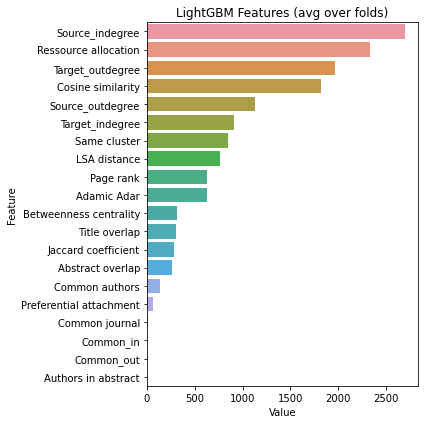

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
feature_imp = pd.DataFrame(sorted(zip(lgb_class.feature_importances_,features)), columns=['Value','Feature']).sort_values(by='Value',ascending=False)

plt.figure(figsize=(6,6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

### Best scoring model for kaggle

In [48]:
test_features = preprocessing.scale(test_tot)
train_features = preprocessing.scale(train_tot)

clf = MLPClassifier(solver='adam', alpha=1.94e-3,activation="relu",
            hidden_layer_sizes=(72,36), tol=5e-5, max_iter=250, verbose=1)
history = clf.fit(train_features,labels_array)
pred = list(clf.predict(test_features))

predictions= zip(range(len(test_features)), pred)

## write predictions to .csv file suitable for Kaggle
with open("predictions_final.csv","w",newline="") as pred1: #used for final leader board standing
    fieldnames = ['id', 'category']
    csv_out = csv.writer(pred1)
    csv_out.writerow(fieldnames)
    for row in predictions:
        csv_out.writerow(row)

Iteration 1, loss = 0.07287233
Iteration 2, loss = 0.06226998
Iteration 3, loss = 0.05993556
Iteration 4, loss = 0.05888471
Iteration 5, loss = 0.05786364
Iteration 6, loss = 0.05711964
Iteration 7, loss = 0.05667357
Iteration 8, loss = 0.05618423
Iteration 9, loss = 0.05578814
Iteration 10, loss = 0.05560508
Iteration 11, loss = 0.05525880
Iteration 12, loss = 0.05500978
Iteration 13, loss = 0.05466047
Iteration 14, loss = 0.05449379
Iteration 15, loss = 0.05433586
Iteration 16, loss = 0.05422975
Iteration 17, loss = 0.05408793
Iteration 18, loss = 0.05404247
Iteration 19, loss = 0.05382798
Iteration 20, loss = 0.05359645
Iteration 21, loss = 0.05350923
Iteration 22, loss = 0.05342464
Iteration 23, loss = 0.05321260
Iteration 24, loss = 0.05313832
Iteration 25, loss = 0.05314481
Iteration 26, loss = 0.05296655
Iteration 27, loss = 0.05280177
Iteration 28, loss = 0.05282349
Iteration 29, loss = 0.05261201
Iteration 30, loss = 0.05251158
Iteration 31, loss = 0.05248052
Iteration 32, los

In [59]:
f1_score(labels_array,clf.predict(train_features))

0.9861546557895663

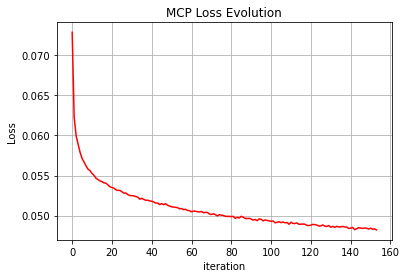

In [65]:
plt.plot(clf.loss_curve_,'r')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.title("MCP Loss Evolution")
plt.grid()
plt.show()